<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
## **Capstone Project: Ride BigApple** 🚖🍎

---
**Pre Processing and Modeling**

In [1]:
# import personal library
import importlib.util
import sys

path_to_library = '../scripts/personal_library.py'

# load module
spec = importlib.util.spec_from_file_location('personal_library', path_to_library)
lu = importlib.util.module_from_spec(spec)
sys.modules['personal_library'] = lu
spec.loader.exec_module(lu)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [4]:
# maps module
#import googlemaps

# import geodesic module
# from geopy.distance import geodesic

In [5]:
# read in file
file_path = '../data/clean_data/taxi_clean_set_v2.csv'

taxi = pd.read_csv(file_path, index_col = 'key')
print(taxi.shape)

(53351, 12)


In [11]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance'],
      dtype='object')

----
**Baseline Model**

In [14]:
# x matrix
X1 = taxi[['geodesic_distance']]

# y target
y1 = taxi['fare_amount']

# check dimensions
X1.shape, y1.shape

((53351, 1), (53351,))

In [16]:
# train/test split, default of 75/25

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 1976)

In [18]:
# check dimensions
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((40013, 1), (13338, 1), (40013,), (13338,))

In [20]:
# instantiate linear model
lr1 = LinearRegression()

In [22]:
# fit linear model
lr1.fit(X_train1, y_train1)

LinearRegression()

In [24]:
round(lr1.score(X_train1, y_train1), 3)

0.812

In [26]:
round(lr1.score(X_test1, y_test1), 3)

0.822

In [28]:
y_preds1 = lr1.predict(X_test1)
y_preds1

array([17.23535219, 13.58803121,  9.1944752 , ...,  8.94292313,
       16.61563814,  7.02778828])

In [30]:
round(root_mean_squared_error(y_test1, y_preds1), 2)

3.89

---
**Clustering**

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [34]:
# P matrix, for pickup coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

P = np.radians(taxi[['pickup_longitude', 'pickup_latitude']].values)
P.shape

(53351, 2)

**Epsilon**<br>
With about 90% of pickups ocurring in Manhattan, let's focus on finding a value for epsilon that is based on the Manhattan grid.<br><br>
Avenues run north-south and viceversa (6th Avenue, 7th Avenue, Broadway, etc.). And streets run east-west/viceversa (57th Street, 34th Street, Houston Street, etc.).  So, we'll call a city block a block from one street to the next, either north or south.  Based on <a href = 'https://gottalovenewyork.com/what-is-the-size-of-manhattan/'>research</a>, the approximate length of a standard city block is about 80 meters, which in degrees (since we're using longitude/latitude data) is approximately 0.00072.<br><br>
A good distance to cluster rides around would range from 1 city block to 5 city blocks.  In meters that would range from 80 meters to 400 meters.  And for the values of epsilon, that would range from  0.00072 degrees to 0.00360 degress.<br><br>
Since this is geographical/spatial data, the metric  for `DBSCAN` must be **Haversine** in order to take into account longitude and latitude coordinates as well as the earth's curvature.

In [36]:
# values of epsilon to try
epsilons = np.linspace(0.00072, 0.00360, 5)

# conversion factor to turn epsilon into radians
radians_conversion = (np.pi / 180)

# mininum number of rides to cluster
minimum_rides = [30, 45, 60]

In [46]:
%%time
# this will be time consuming, let's measure it to have an idea for future iterations

results = []

# determine best combination
for eps in epsilons:
    for rides in minimum_rides:
        dbs = DBSCAN(
        # using Haversine distance, so it must be converted to radians
        eps = eps * radians_conversion,         
        # only consider clusters based on certain number of pickups within the search radius                 
        min_samples = rides,
        # use Haversine distance, which measures actual distance over earth's surface
        metric = 'haversine',
        n_jobs = -1)

        dbs.fit(P)
        labels = dbs.labels_

        clusters = len(np.unique(labels[labels != -1]))
    
        silhouette = silhouette_score(P, labels, metric='haversine') if clusters > 1 else -1
        
        results.append(
            {'epsilon': eps, 
             'min_samples': rides, 
             'clusters': clusters, 
             'silhouette_score': silhouette}
        )
    print(f'Epsilon {eps} done.')

Epsilon 0.00072 done.
Epsilon 0.0014399999999999999 done.
Epsilon 0.00216 done.
Epsilon 0.0028799999999999997 done.
Epsilon 0.0036 done.
CPU times: total: 47min 36s
Wall time: 1h 5min 37s


In [48]:
summary_table = pd.DataFrame(results)
summary_table

,epsilon,min_samples,clusters,silhouette_score
0,0.00072,30,16,-0.470738
1,0.00072,45,17,-0.431408
2,0.00072,60,21,-0.493909
3,0.00144,30,11,-0.038394
4,0.00144,45,11,-0.082117
5,0.00144,60,7,0.251721
6,0.00216,30,10,0.088988
7,0.00216,45,8,-0.045404
8,0.00216,60,5,-0.024897
9,0.00288,30,9,0.256899


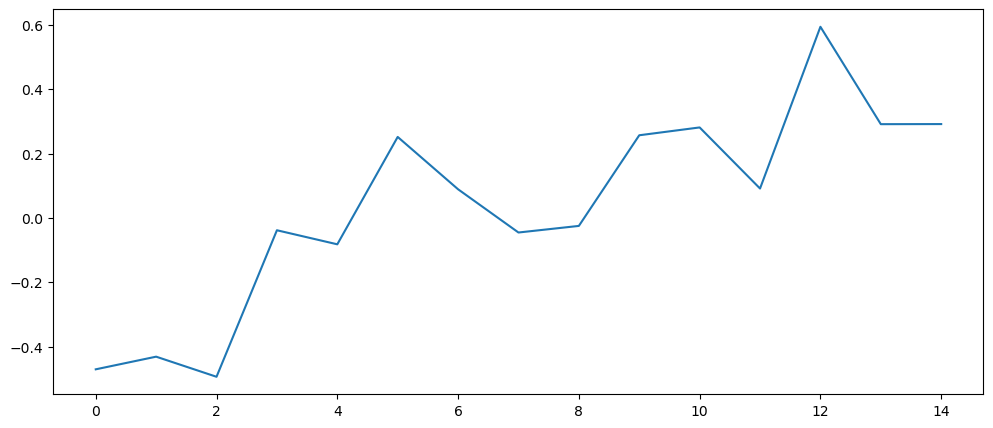

In [60]:
# plot silhouette scores
plt.figure(figsize = (12, 5))
plt.plot(summary_table['silhouette_score']);

In [38]:
# replicate DBS with eps=0.00360 (5 blocks), mininum rides = 30
dbs = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 30, 
             metric = 'haversine')

In [40]:
# fit model
dbs.fit(P)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=30)

In [66]:
# confirm silhouette score
silhouette_score(P, dbs.labels_, metric = 'haversine')

0.594171723161251

In [42]:
# add pickup clusters column
taxi['pickup_clusters'] = dbs.labels_

In [44]:
# check counts
taxi['pickup_clusters'].value_counts()

pickup_clusters
 0    50752
 1      912
 3      774
-1      440
 2      414
 4       59
Name: count, dtype: int64

In [46]:
color_map = {
 -1: '#c7c7c7',
  0: '#ac2020',    # manhattan, downtown brooklyn, willliamsburg
  1: '#052f5f',    # lga airport
  2: '#f77f00',    # long island city and surrounding area
  3: '#17b890',    # jfk airport
  4: '#007fff',    # just outside lga
  #5: '#ffaa66',
  #6: '#ffbb80',
  #7: '#ffcc99'
}

In [48]:
taxi['pickup_clusters_color'] = taxi['pickup_clusters'].map(color_map)

In [50]:
taxi['pickup_clusters_color'].value_counts()

pickup_clusters_color
#ac2020    50752
#052f5f      912
#17b890      774
#c7c7c7      440
#f77f00      414
#007fff       59
Name: count, dtype: int64

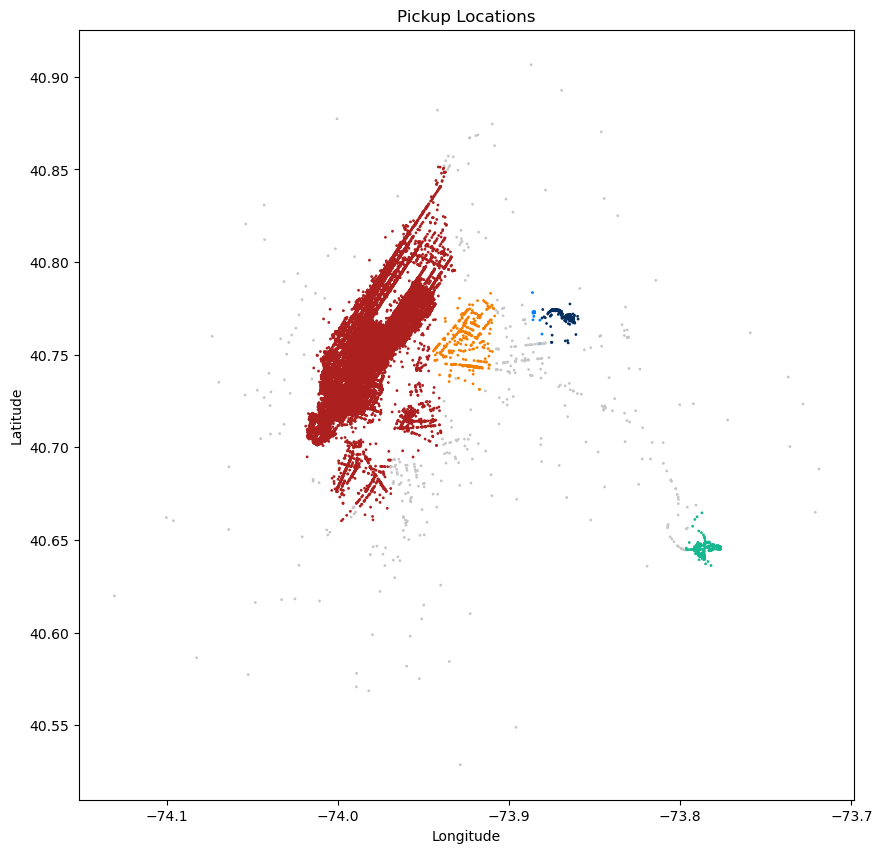

In [52]:
plt.figure(figsize = (10, 10))
# plot pickup locations and clusters
# sns.scatterplot(taxi,
#                 x = 'pickup_longitude',
#                 y = 'pickup_latitude', hue = 'pickup_clusters_color', size = 1, palette = None);

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Pickup Locations')
plt.scatter(taxi['pickup_longitude'],
            taxi['pickup_latitude'], 
            c = taxi['pickup_clusters_color'], 
            s = 1);
#plt.savefig('pickup_locations.png');

In [54]:
dummy_col_pickups = pd.get_dummies(taxi['pickup_clusters'], prefix = 'p', prefix_sep = '_', drop_first = True, dtype = int)

In [56]:
dummy_col_pickups.shape

(53351, 5)

In [58]:
print(f'Before: {taxi.shape}')
taxi = pd.concat([taxi, dummy_col_pickups], axis = 1)
print(f'After: {taxi.shape}')

Before: (53351, 14)
After: (53351, 19)


In [60]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4'],
      dtype='object')

---
**Updated Linear Model**

In [63]:
cols_to_drop = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'pickup_clusters', 'pickup_clusters_color']

In [65]:
X = taxi.drop(columns = cols_to_drop)
y = taxi['fare_amount']

X.shape, y.shape

((53351, 6), (53351,))

In [67]:
X.columns

Index(['geodesic_distance', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4'], dtype='object')

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 6), (13338, 6), (40013,), (13338,))

In [71]:
lr2 = LinearRegression()

In [73]:
lr2.fit(X_train, y_train)

LinearRegression()

In [75]:
round(lr2.score(X_train, y_train), 3)

0.817

In [77]:
round(lr2.score(X_test, y_test), 3)

0.827

In [79]:
y_preds = lr2.predict(X_test)
y_preds

array([16.99230052, 13.42216805,  9.12159318, ...,  8.87536472,
       16.38570152,  7.00076001])

In [81]:
round(root_mean_squared_error(y_test, y_preds), 2)

3.84

------
**Dropoffs**

In [84]:
# D matrix, for dropoff coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

D = np.radians(taxi[['dropoff_longitude', 'dropoff_latitude']].values)
D.shape

(53351, 2)

In [86]:
# the data for dropoffs is in the same format, so use what we know already works
# replicate DBS with eps=0.00360 (5 blocks), mininum rides = 30
dbs2 = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 30, 
             metric = 'haversine')

In [88]:
dbs2.fit(D)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=30)

In [114]:
silhouette_score(D, dbs2.labels_, metric = 'haversine')

0.5437444328197156

In [90]:
# add dropoff clusters column
taxi['dropoff_clusters'] = dbs2.labels_

In [92]:
taxi['dropoff_clusters'].value_counts()

dropoff_clusters
 0    51006
-1     1205
 1      688
 2      346
 3       70
 4       36
Name: count, dtype: int64

In [312]:
color_map2 = {
 -1: '#c7c7c7',
  0: '#ff0000',
  1: '#ff6600',
  2: '#ff7719',
  3: '#ff8833',
  4: '#ff994d',
  5: '#ffaa66'
}

In [94]:
taxi['dropoff_clusters_color'] = taxi['dropoff_clusters'].map(color_map)

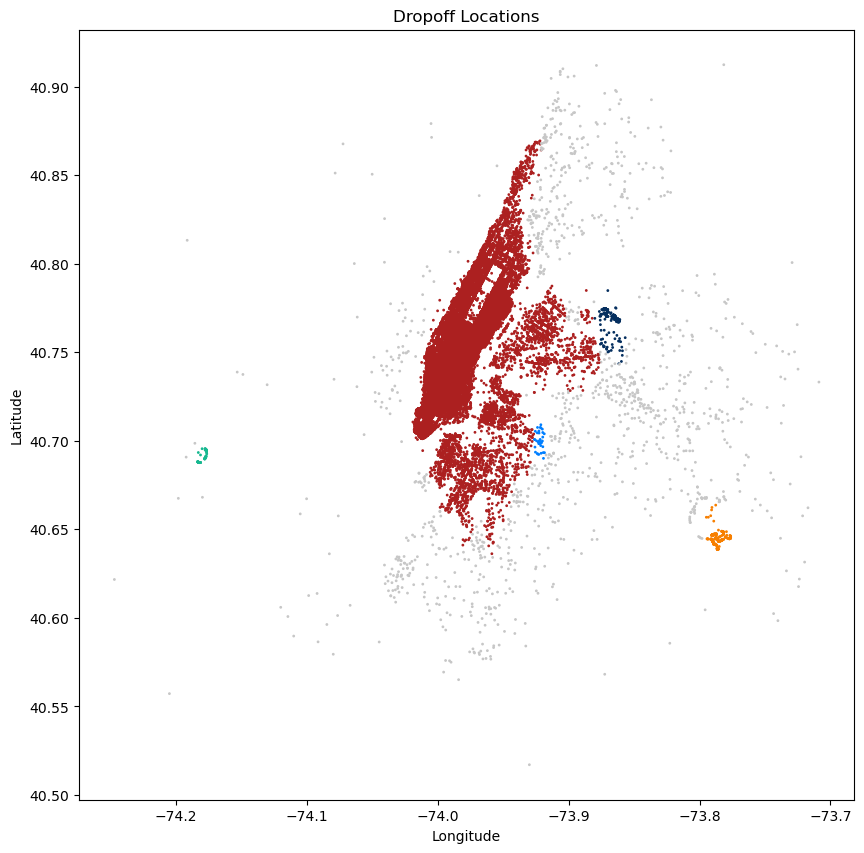

In [96]:
plt.figure(figsize = (10, 10))
# plot dropoff locations and clusters

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Dropoff Locations')
plt.scatter(taxi['dropoff_longitude'],
            taxi['dropoff_latitude'], 
            c = taxi['dropoff_clusters_color'], 
            s = 1);
#plt.savefig('pickup_locations.png');

In [98]:
dummy_col_dropoffs = pd.get_dummies(taxi['dropoff_clusters'], prefix = 'd', prefix_sep = '_', drop_first = True, dtype = int)

In [100]:
dummy_col_dropoffs.shape

(53351, 5)

In [102]:
print(taxi.shape)
taxi = pd.concat([taxi, dummy_col_dropoffs], axis = 1)
print(taxi.shape)

(53351, 21)
(53351, 26)


In [104]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4'],
      dtype='object')

In [106]:
# update
cols_to_drop.append('dropoff_clusters')
cols_to_drop.append('dropoff_clusters_color')

**Updated Linear Model Part 2**

In [109]:
X = taxi.drop(columns = cols_to_drop)
y = taxi['fare_amount']

X.shape, y.shape

((53351, 11), (53351,))

In [111]:
X.columns

Index(['geodesic_distance', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4'],
      dtype='object')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)

In [115]:
lr3 = LinearRegression()

In [117]:
lr3.fit(X_train, y_train)

LinearRegression()

In [119]:
lr3.score(X_train, y_train)

0.8358062660050452

In [121]:
lr3.score(X_test, y_test)

0.8400317676031234

In [123]:
y_preds = lr3.predict(X_test)

In [125]:
root_mean_squared_error(y_test, y_preds)

3.6964470249177337

----
#### **Feature Engineering**

---
**Estimated Distance**

Expand, but gist for now: distance is a major driver, but right now dealing with geodesic distances.  At NYC's latitude, and taking the Manhattan grid into account.  Once geo distances exceed 10km the gap between geo and actual increases.  So, in a new column, estimate actual distance by a factor of 1.15 if less than 10km, and by 1.2 if 10km or greater.

In [130]:
taxi['estimated_distance'] = taxi['geodesic_distance'].map(lambda x: x*1.15 if x < 10 else x*1.2)

In [132]:
taxi[taxi['geodesic_distance'] > 9.5][['geodesic_distance', 'estimated_distance']].tail(10)

,geodesic_distance,estimated_distance
key,,
2014-12-22 14:15:33.000000100,19.623346,23.548015
2014-12-23 03:58:24.000000100,18.487984,22.185581
2014-12-23 10:19:00.000000270,10.787218,12.944662
2014-12-24 01:06:43.000000100,9.857828,11.336502
2014-12-28 04:08:39.000000100,9.656063,11.104472
2014-12-28 13:11:00.000000460,11.017346,13.220815
2014-12-29 14:08:00.000000660,13.823438,16.588125
2014-12-29 17:12:09.000000600,10.880215,13.056258
2014-12-30 22:14:15.000000100,11.672256,14.006707


In [134]:
# update
cols_to_drop.append('geodesic_distance')

In [136]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance'],
      dtype='object')

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 11), (13338, 11), (40013,), (13338,))

In [140]:
lr4 = LinearRegression()
lr4.fit(X_train, y_train)

LinearRegression()

In [142]:
print(lr4.score(X_train, y_train))
print(lr4.score(X_test, y_test))

0.8349226214361809
0.8394184235685541


In [144]:
preds = lr4.predict(X_test)
root_mean_squared_error(y_test, preds)

3.703526632716779

----
**Dollars per Km**

Gist, expand later: In the absence of duration data, the closest proxy would be dollars spend per traveled kilometer.  Now we we have a closer approximation of the actual distance traveled, if we divide the fare by distance we should see differences for trips of the same distance having different fare because one took longer than the other, thus having to pay extra for sitting in traffic, which is one of the fare components.

In [148]:
taxi['usd_per_km'] = taxi['fare_amount']/taxi['estimated_distance']
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'estimated_distance', 'usd_per_km'],
      dtype='object')

In [150]:
taxi[['fare_amount','estimated_distance', 'usd_per_km']].head()

,fare_amount,estimated_distance,usd_per_km
key,,,
2009-01-01 00:48:11.000000200,11.0,5.196234,2.116918
2009-01-01 00:54:13.000000100,12.2,5.135030,2.375838
2009-01-01 01:07:13.000000100,5.4,1.451833,3.719435
2009-01-01 01:12:02.000000100,11.0,4.061769,2.708180
2009-01-01 04:34:56.000000100,8.2,1.855340,4.419674


In [152]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km'],
      dtype='object')

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 12), (13338, 12), (40013,), (13338,))

In [156]:
lr5 = LinearRegression()
lr5.fit(X_train, y_train)

LinearRegression()

In [158]:
print(lr5.score(X_train, y_train))
print(lr5.score(X_test, y_test))

0.8751850161458878
0.875204995624856


In [160]:
preds = lr5.predict(X_test)
root_mean_squared_error(y_test, preds)

3.2648724098241

----
**Interaction: Distance by Hour**

Go back to this...

In [164]:
taxi['dist_hour'] = taxi['estimated_distance'] * taxi['hour']
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'estimated_distance', 'usd_per_km', 'dist_hour'],
      dtype='object')

In [166]:
taxi[['hour', 'estimated_distance', 'dist_hour']].tail()

,hour,estimated_distance,dist_hour
key,,,
2014-12-31 21:09:00.000000105,21,2.233709,46.907891
2014-12-31 21:12:05.000000400,21,2.242638,47.095392
2014-12-31 21:14:00.000000530,21,3.396973,71.336424
2014-12-31 21:56:56.000000400,21,2.624545,55.115447
2014-12-31 22:04:00.000000175,22,2.357478,51.864526


In [168]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour'],
      dtype='object')

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 13), (13338, 13), (40013,), (13338,))

In [172]:
lr6 = LinearRegression()
lr6.fit(X_train, y_train)

LinearRegression()

In [174]:
print(lr6.score(X_train, y_train))
print(lr6.score(X_test, y_test))

0.8753483232850284
0.8755908843240354


In [176]:
preds = lr6.predict(X_test)
root_mean_squared_error(y_test, preds)

3.259820713947516

----
**Airport Rides**

Gist, fix later: special fares with airport rides. From JFK to Manhattan is flat rate, from/to LGA there's a surcharge, to EWR there's also a surcharge.

In [180]:
def is_airport(row):
    if row['pickup_clusters'] == 1 or row['dropoff_clusters'] == 1:
        return 'LGA'
    elif row['pickup_clusters'] == 3 or row['dropoff_clusters'] == 2:
        return 'JFK'
    elif row['dropoff_clusters'] == 3:
        return 'EWR'
    else:
        return None

In [182]:
# apply to df and create column
taxi['airport_ride'] = taxi.apply(is_airport, axis = 1)

In [183]:
taxi['airport_ride'].value_counts(dropna = False)

airport_ride
None    50605
LGA      1588
JFK      1089
EWR        69
Name: count, dtype: int64

In [186]:
# dummify airport_ride
dummy_col_airport = pd.get_dummies(taxi['airport_ride'], drop_first = True, dtype = int)
dummy_col_airport.shape

(53351, 2)

In [188]:
print(taxi.shape)
taxi = pd.concat([taxi, dummy_col_airport], axis = 1)
print(taxi.shape)

(53351, 30)
(53351, 32)


In [190]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'estimated_distance', 'usd_per_km', 'dist_hour',
       'airport_ride', 'JFK', 'LGA'],
      dtype='object')

In [192]:
# update
cols_to_drop.append('airport_ride')

In [194]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour', 'JFK', 'LGA'],
      dtype='object')

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 15), (13338, 15), (40013,), (13338,))

In [198]:
lr7 = LinearRegression()
lr7.fit(X_train, y_train)

LinearRegression()

In [200]:
print(lr7.score(X_train, y_train))
print(lr7.score(X_test, y_test))

0.8765152158438572
0.8766377523266417


In [202]:
preds = lr7.predict(X_test)
round(root_mean_squared_error(y_test, preds), 3)

3.246

---
**Peak Rides**

In [205]:
taxi['peak_rides'] = 0
taxi['peak_rides'].head()

key
2009-01-01 00:48:11.000000200    0
2009-01-01 00:54:13.000000100    0
2009-01-01 01:07:13.000000100    0
2009-01-01 01:12:02.000000100    0
2009-01-01 04:34:56.000000100    0
Name: peak_rides, dtype: int64

In [207]:
# this crazy logic required chatgpt intervation, what I was creating on my own got too convoluted too quickly
# Filter for weekdays (not Saturday or Sunday)
weekday_condition = ~taxi['day_of_week'].isin(['Saturday', 'Sunday'])

# Filter for the morning time range (6:30 AM to 9:30 AM)
morning_condition = (taxi['hour'] >= 6) & (taxi['hour'] <= 9) & ((taxi['hour'] != 6) | (taxi['minute'] >= 30)) & ((taxi['hour'] != 9) | (taxi['minute'] <= 30))

# Filter for the afternoon time range (3:00 PM to 8:00 PM)
afternoon_condition = (taxi['hour'] >= 15) & (taxi['hour'] <= 20)

In [209]:
indexes = taxi[weekday_condition & (morning_condition | afternoon_condition)].index
taxi.loc[indexes, 'peak_rides'] = 1

In [211]:
taxi['peak_rides'].value_counts()

peak_rides
0    35151
1    18200
Name: count, dtype: int64

In [213]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour', 'JFK', 'LGA',
       'peak_rides'],
      dtype='object')

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 16), (13338, 16), (40013,), (13338,))

In [217]:
lr8 = LinearRegression()
lr8.fit(X_train, y_train)

LinearRegression()

In [219]:
print(lr8.score(X_train, y_train))
print(lr8.score(X_test, y_test))

0.8766154836404968
0.8767810641041482


In [221]:
preds = lr8.predict(X_test)
round(root_mean_squared_error(y_test, preds), 3)

3.244

----
**Weekend Rides**

Lore ipsum...

In [227]:
weekend_condition = taxi['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_condition.value_counts()

day_of_week
False    38290
True     15061
Name: count, dtype: int64

In [229]:
taxi['weekend_rides'] = 0

In [231]:
indexes = taxi[weekend_condition].index
taxi.loc[indexes, 'weekend_rides'] = 1

In [233]:
taxi['weekend_rides'].value_counts()

weekend_rides
0    38290
1    15061
Name: count, dtype: int64

In [235]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides'],
      dtype='object')

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 17), (13338, 17), (40013,), (13338,))

In [239]:
lr9 = LinearRegression()
lr9.fit(X_train, y_train)

LinearRegression()

In [243]:
print(lr9.score(X_train, y_train))
print(lr9.score(X_test, y_test))

0.8766676050652019
0.87682330557837


In [245]:
preds = lr9.predict(X_test)
round(root_mean_squared_error(y_test, preds), 3)

3.244

-----
**Holiday Rides**

In [248]:
holiday_condition = taxi['month'].isin(['November', 'December'])
holiday_condition.value_counts()

month
False    44628
True      8723
Name: count, dtype: int64

In [250]:
taxi['holiday_rides'] = 0

In [252]:
indexes = taxi[holiday_condition].index
taxi.loc[indexes, 'holiday_rides'] = 1

In [264]:
taxi['holiday_rides'].value_counts()

holiday_rides
0    44628
1     8723
Name: count, dtype: int64

In [254]:
X = taxi.drop(columns = cols_to_drop)
X.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40013, 18), (13338, 18), (40013,), (13338,))

In [258]:
lr10 = LinearRegression()
lr10.fit(X_train, y_train)

LinearRegression()

In [260]:
print(lr10.score(X_train, y_train))
print(lr10.score(X_test, y_test))

0.8768299081641576
0.8768112240283205


In [262]:
preds = lr10.predict(X_test)
round(root_mean_squared_error(y_test, preds), 3)

3.244

----
#### **Feature Selection**

----
**Lasso**

In [271]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [273]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ls', Lasso(random_state = 1976))             
])

In [275]:
params = {
    'ls__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

In [277]:
gs = GridSearchCV(pipe,
                  param_grid = params,
                  verbose = 1,
                  n_jobs = -1
                 )

In [281]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ls', Lasso(random_state=1976))]),
             n_jobs=-1,
             param_grid={'ls__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             verbose=1)

In [295]:
gs.best_params_

{'ls__alpha': 0.0001}

In [297]:
gs.best_score_

0.8759181005298867

In [299]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [301]:
ls = Lasso(alpha = gs.best_params_['ls__alpha'], 
           random_state = 1976
          )

In [305]:
ls.fit(X_train_sc, y_train)

Lasso(alpha=0.0001, random_state=1976)

In [311]:
print(ls.score(X_train_sc, y_train))
print(ls.score(X_test_sc, y_test))

0.8768298055203677
0.8768113220999072


In [315]:
preds = ls.predict(X_test_sc)
round(root_mean_squared_error(preds, y_test), 3)

3.244

In [361]:
ls.coef_

array([ 0.02685799, -0.66541485,  0.0972908 , -1.48400827,  0.22295887,
       -0.09198511, -0.66269491, -1.07802061,  0.93907413,  0.01754083,
        8.49177299,  2.01822364,  0.18840732,  1.58859558,  1.70445541,
        0.06013893, -0.07423899,  0.11623626])

In [331]:
X_train.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'estimated_distance', 'usd_per_km', 'dist_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [367]:
keys = X_train.columns
values = [round(i, 2) for i in ls.coef_]

In [387]:
coefficients_table = dict(zip(keys, values))
pd.Series(coefficients_table)

p_0                   0.03
p_1                  -0.67
p_2                   0.10
p_3                  -1.48
p_4                   0.22
d_0                  -0.09
d_1                  -0.66
d_2                  -1.08
d_3                   0.94
d_4                   0.02
estimated_distance    8.49
usd_per_km            2.02
dist_hour             0.19
JFK                   1.59
LGA                   1.70
peak_rides            0.06
weekend_rides        -0.07
holiday_rides         0.12
dtype: float64

In [389]:
features_to_keep = keys[np.abs(values) >= 0.1]
print(f'Count: {len(features_to_keep)}')
features_to_keep

Count: 13


Index(['p_1', 'p_2', 'p_3', 'p_4', 'd_1', 'd_2', 'd_3', 'estimated_distance',
       'usd_per_km', 'dist_hour', 'JFK', 'LGA', 'holiday_rides'],
      dtype='object')

In [393]:
X2 = taxi[features_to_keep]
X2.shape

(53351, 13)

In [397]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, random_state = 1976)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((40013, 13), (13338, 13), (40013,), (13338,))

In [401]:
X2_train_sc = sc.fit_transform(X2_train)
X2_test_sc = sc.transform(X2_test)

In [405]:
ls2 = Lasso(alpha = gs.best_params_['ls__alpha'], random_state = 1976)
ls2.fit(X2_train_sc, y2_train)

Lasso(alpha=0.0001, random_state=1976)

In [409]:
print(ls2.score(X2_train_sc, y2_train))
print(ls2.score(X2_test_sc, y2_test))

0.8766227758985069
0.8765379435345985


In [411]:
preds = ls2.predict(X2_test_sc)
round(root_mean_squared_error(preds, y2_test), 3)

3.247

-----
**XG Boost**

In [414]:
from xgboost import XGBRegressor

In [416]:
xgb = XGBRegressor()
xgb.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [420]:
print(xgb.score(X2_train, y2_train))
print(xgb.score(X2_test, y2_test))

0.9982790060297466
0.9913658305518633


In [418]:
preds = xgb.predict(X2_test)
round(root_mean_squared_error(preds, y2_test), 3)

0.859

Winner!

In [431]:
taxi.to_csv('../data/clean_data/taxi_clean_set_v3.csv')